## The CIFAR-10 dataset for classification

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<img src="images/cfifar-10.png" width="40%" height="20%">

[Cifar-10 source](https://www.cs.toronto.edu/~kriz/cifar.html)

In [30]:
import ray

from ray import serve
from ray.serve import PredictorDeployment
from ray.data.datasource import SimpleTorchDatasource
import air_utils as aut

from ray.train.torch import TorchTrainer
from ray.air.config import ScalingConfig

from ray.train.torch import TorchPredictor
from ray.train.batch_predictor import BatchPredictor

import torch
import numpy as np
import pandas as pd
import requests

### Step 1. Fetch Data

In [31]:
train_dataset: ray.data.Dataset = ray.data.read_datasource(SimpleTorchDatasource(), dataset_factory=aut.train_dataset_factory)
test_dataset: ray.data.Dataset = ray.data.read_datasource(SimpleTorchDatasource(), dataset_factory=aut.test_dataset_factory)

2022-10-03 19:11:21,640	WARNING read_api.py:295 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
(_get_read_tasks pid=79665) 2022-10-03 19:11:21,638	WARNING torch_datasource.py:55 -- `SimpleTorchDatasource` doesn't support parallel reads. The `parallelism` argument will be ignored.


(_execute_read_task pid=79665) Files already downloaded and verified


2022-10-03 19:11:26,870	WARNING read_api.py:295 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
(_get_read_tasks pid=79665) 2022-10-03 19:11:26,868	WARNING torch_datasource.py:55 -- `SimpleTorchDatasource` doesn't support parallel reads. The `parallelism` argument will be ignored.


(_execute_read_task pid=79665) Files already downloaded and verified


In [32]:
train_dataset = train_dataset.repartition(4)
test_dataset = test_dataset.repartition(2)

(_map_block_nosplit pid=79665) Files already downloaded and verified
(_map_block_nosplit pid=79665) Files already downloaded and verified


In [33]:
print(train_dataset)

Dataset(num_blocks=4, num_rows=50000, schema=<class 'tuple'>)


### Step 2: Create a preprocessor to transform data
* Transform data into Pandas DataFrame
* Convert training and testing datasets into Panda DataFrame
* Use dataset map_batches to convert 

In [38]:
train_dataset = train_dataset.map_batches(aut.convert_batch_to_pandas)
test_dataset = test_dataset.map_batches(aut.convert_batch_to_pandas)

AttributeError: module 'air_utils' has no attribute 'convert_batch_to_pandas'

### Step 3: Train using Ray AIR's TorchTrainer

We will use a batch_size of 5, 50 epochs, scale to 5 workers.
Ray AIR TorchTrainer automatically creates `Checkpoint` objects. Fetch the last
checkpoint.

In [18]:
trainer = TorchTrainer(
        train_loop_per_worker=aut.train_loop_per_worker,
        train_loop_config={"batch_size": 4, "epochs": 50},
        datasets={"train": train_dataset},
        scaling_config=ScalingConfig(num_workers=5) # try mulitples of 2, 4, 6, 8
    )

result = trainer.fit()
latest_checkpoint = result.checkpoint

(RayTrainWorker pid=40491) 2022-10-03 10:05:27,082	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=5]
(RayTrainWorker pid=40492) [W ProcessGroupGloo.cpp:715] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=40493) [W ProcessGroupGloo.cpp:715] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=40494) [W ProcessGroupGloo.cpp:715] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=40491) [W ProcessGroupGloo.cpp:715] Warning: Unable to resolve hostname to a (local) address. Using the loo

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
TorchTrainer_91d72_00000,2022-10-03_10-05-25,6d72facd017341e1bb9b4d2bbdb22d4f,Juless-MacBook-Pro-16,127.0.0.1,40483,1664816725,91d72_00000


2022-10-03 10:05:33,669	ERROR tune.py:758 -- Trials did not complete: [TorchTrainer_91d72_00000]
2022-10-03 10:05:33,669	INFO tune.py:762 -- Total run time: 9.95 seconds (9.84 seconds for the tuning loop).


RayTaskError(TypeError): [36mray::_Inner.train()[39m (pid=40483, ip=127.0.0.1, repr=TorchTrainer)
  File "/Users/jules/git-repos/ray/python/ray/tune/trainable/trainable.py", line 353, in train
    raise skip_exceptions(e) from None
  File "/Users/jules/git-repos/ray/python/ray/train/_internal/utils.py", line 54, in check_for_failure
    ray.get(object_ref)
ray.exceptions.RayTaskError(TypeError): [36mray::RayTrainWorker._RayTrainWorker__execute()[39m (pid=40492, ip=127.0.0.1, repr=<ray.train._internal.worker_group.RayTrainWorker object at 0x10b9a75e0>)
  File "/Users/jules/git-repos/ray/python/ray/train/_internal/worker_group.py", line 30, in __execute
    raise skip_exceptions(e) from None
  File "/Users/jules/git-repos/ray/python/ray/train/_internal/utils.py", line 129, in discard_return_wrapper
    train_func(*args, **kwargs)
  File "/Users/jules/git-repos/misc-code/py/ray/rayair/air_utils.py", line 114, in train_loop_per_worker
    for i, data in enumerate(train_dataset_shard):
  File "/Users/jules/git-repos/ray/python/ray/data/dataset.py", line 2525, in iter_torch_batches
    yield convert_ndarray_batch_to_torch_tensor_batch(
  File "/Users/jules/git-repos/ray/python/ray/air/_internal/torch_utils.py", line 166, in convert_ndarray_batch_to_torch_tensor_batch
    batch = {
  File "/Users/jules/git-repos/ray/python/ray/air/_internal/torch_utils.py", line 167, in <dictcomp>
    col_name: convert_ndarray_to_torch_tensor(
  File "/Users/jules/git-repos/ray/python/ray/air/_internal/torch_utils.py", line 135, in convert_ndarray_to_torch_tensor
    return torch.as_tensor(ndarray, dtype=dtype, device=device)
TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

### Step 5: Use `TorchPredictor` using the `Checkpoint` object

* Test our model with TorchPredictor using the Checkpoint object.
* Fetch the best_checkpoint from the lastest checkpoint. 
* Use batch predictor to test the entire batch in one go

In [24]:
predict_dataset = test_dataset.drop_columns(cols=["label"])
batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint=latest_checkpoint,
    predictor_cls=TorchPredictor,
    model=Net()
    )

output: ray.data.Dataset = batch_predictor.predict(
        data=test_dataset, dtype=torch.float, 
        feature_columns=["image"], 
        keep_columns=["label"]
    )

Map Progress (1 actors 1 pending):   0%|          | 0/1 [00:01<?, ?it/s](BlockWorker pid=95364) /Users/jules/git-repos/ray/python/ray/air/util/data_batch_conversion.py:158: SettingWithCopyWarning: 
(BlockWorker pid=95364) A value is trying to be set on a copy of a slice from a DataFrame.
(BlockWorker pid=95364) Try using .loc[row_indexer,col_indexer] = value instead
(BlockWorker pid=95364) 
(BlockWorker pid=95364) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(BlockWorker pid=95364)   df.loc[:, col_name] = TensorArray(col)
(BlockWorker pid=95364) /Users/jules/git-repos/ray/python/ray/air/util/data_batch_conversion.py:158: SettingWithCopyWarning: 
(BlockWorker pid=95364) A value is trying to be set on a copy of a slice from a DataFrame.
(BlockWorker pid=95364) Try using .loc[row_indexer,col_indexer] = value instead
(BlockWorker pid=95364) 
(BlockWorker pid=95364) See the caveats in the documenta

In [25]:
# get the predictions
predictions = output.map_batches(aut.convert_logits_to_classes, batch_format="pandas")

# Get all predictions for test_dataset 
scores = predictions.map_batches(aut.calculate_prediction_scores)

# compute total prediction accuracy. That is all predictions equal to ground truth
# That is, predictated accurately.
total_acc = scores.sum(on="correct") / scores.count()
print(f"Prediction accuracy from the test data of 10,000 images: {total_acc:.2f}")

(BlockWorker pid=95364) /Users/jules/git-repos/ray/python/ray/air/util/data_batch_conversion.py:158: SettingWithCopyWarning: 
(BlockWorker pid=95364) A value is trying to be set on a copy of a slice from a DataFrame.
(BlockWorker pid=95364) Try using .loc[row_indexer,col_indexer] = value instead
(BlockWorker pid=95364) 
(BlockWorker pid=95364) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(BlockWorker pid=95364)   df.loc[:, col_name] = TensorArray(col)
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 350.61it/s]

Prediction accuracy from the test data of 10,000 images: 0.43


### Step 6: Online prediction
 * Deploy our model to the network for online prediction
 * Use `TorchPredictor` and `PredictorDeployment` APIs
 * Start a Ray serve in detached mode
 
 This will automatically deploy the model from the lastest checkpoint. You can adjist num of replicas in the options
 

In [26]:
serve.start(detached=True)
deployment = PredictorDeployment.options(name="cifar-deployment", num_replicas=2)
deployment.deploy(TorchPredictor, latest_checkpoint, batching_params=False, model=aut.Net(), http_adapter=aut.json_to_numpy)

(ServeController pid=95368) INFO 2022-10-02 09:56:56,944 controller 95368 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-2497ddca0c5b238506672461aa754059e210eb0578066a6a4a6765f6' on node '2497ddca0c5b238506672461aa754059e210eb0578066a6a4a6765f6' listening on '127.0.0.1:8000'
(ServeController pid=95368) INFO 2022-10-02 09:56:57,587 controller 95368 deployment_state.py:1277 - Adding 2 replicas to deployment 'cifar-deployment'.
(HTTPProxyActor pid=95370) INFO:     Started server process [95370]


### Test online prediction from the test data

(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,567 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 307 3.3ms
(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,579 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 200 10.6ms
(ServeReplica:cifar-deployment pid=95372) INFO 2022-10-02 09:56:59,567 cifar-deployment cifar-deployment#CiPXfl replica.py:505 - HANDLE __call__ OK 0.2ms
(ServeReplica:cifar-deployment pid=95373) INFO 2022-10-02 09:56:59,578 cifar-deployment cifar-deployment#KqBNYG replica.py:505 - HANDLE __call__ OK 7.4ms


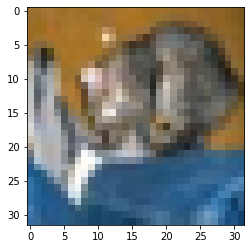

prediction: 6; class: frog; matched: False


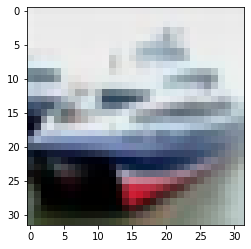

prediction: 8; class: ship; matched: True


(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,628 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 307 2.0ms
(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,635 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 200 5.4ms
(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,678 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 307 1.8ms
(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,684 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 200 5.3ms
(ServeReplica:cifar-deployment pid=95372) INFO 2022-10-02 09:56:59,627 cifar-deployment cifar-deployment#CiPXfl replica.py:505 - HANDLE __call__ OK 0.2ms
(ServeReplica:cifar-deployment pid=95372) INFO 2022-10-02 09:56:59,677 cifar-deployment cifar-deployment#CiPXfl replica.py:505 - HANDLE __call__ OK 0.1ms
(ServeReplica:cifar-deployment pid=95373) INFO 2022-10-02 09:56:59,634 cifar-deployment cifar-deployment#KqBNYG replica.py:505 - HANDLE __call__ OK 3.8ms
(ServeReplica:cifa

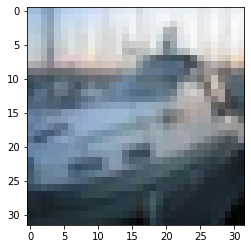

prediction: 1; class: car; matched: False


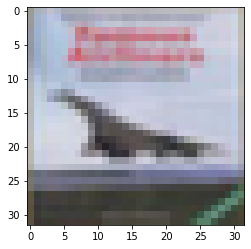

prediction: 8; class: ship; matched: False


(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,728 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 307 1.7ms
(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,735 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 200 5.7ms
(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,777 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 307 1.9ms
(HTTPProxyActor pid=95370) INFO 2022-10-02 09:56:59,784 http_proxy 127.0.0.1 http_proxy.py:315 - POST /cifar-deployment 200 5.6ms
(ServeReplica:cifar-deployment pid=95372) INFO 2022-10-02 09:56:59,727 cifar-deployment cifar-deployment#CiPXfl replica.py:505 - HANDLE __call__ OK 0.1ms
(ServeReplica:cifar-deployment pid=95372) INFO 2022-10-02 09:56:59,777 cifar-deployment cifar-deployment#CiPXfl replica.py:505 - HANDLE __call__ OK 0.1ms
(ServeReplica:cifar-deployment pid=95373) INFO 2022-10-02 09:56:59,734 cifar-deployment cifar-deployment#KqBNYG replica.py:505 - HANDLE __call__ OK 4.2ms
(ServeReplica:cifa

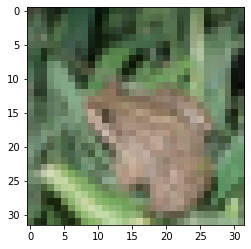

prediction: 4; class: deer; matched: False


In [27]:
# Test online deployment
batch = test_dataset.take(10)
for i in range(5):
    array = np.expand_dims(np.array(batch[i]["image"]), axis=0)
    label = np.array(batch[i]["label"])
    # send request and fetch prediction
    payload  = {"array": array.tolist()}
    response = requests.post(deployment.url, json=payload)
    result = response.json()[0]
    idx, cls = aut.to_prediction_cls(result)
    matched = idx == label
    aut.img_show(batch[i]["image"])
    print(f"prediction: {idx}; class: {cls}; matched: {matched}")

In [28]:
serve.shutdown()

(ServeController pid=95368) INFO 2022-10-02 09:56:59,851 controller 95368 deployment_state.py:1303 - Removing 2 replicas from deployment 'cifar-deployment'.
